# Analysis of Airbnb Data for Seattle from 2017 
##The Analysis attempts to answer 3 basic questions
1. What’s the best time of year to go in terms of rental availability?
2. How much can I expect to pay for a rental?
3. What factors contribute most significantly to the rating for a rental?

### Import packages and load the 3 datasets
### Datasets downloaded from https://www.kaggle.com/datasets/airbnb/seattle

In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import matplotlib as mplib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

listings_df = pd.read_csv('..//Data/listings.csv')
calendar_df = pd.read_csv('..//Data/calendar.csv')
reviews_df = pd.read_csv('..//Data/reviews.csv')


In [2]:
# look at the first 5 records of the calendar dataframe
calendar_df.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
# remove dollar sign and commas so we can work with price as a numeric field 
calendar_df['price'] = calendar_df['price'].str.replace('$','',regex=False)
calendar_df['price'] = calendar_df['price'].str.replace(',','',regex=False)
calendar_df['price'] = pd.to_numeric(calendar_df['price'])

In [4]:
# convert the date column to a datetime
# extract the month from the date and add as a separate column
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df['month'] = calendar_df['date'].dt.month

In [5]:
# create a dataframe of days where a list was available
available_only_df = calendar_df[calendar_df['available'] == 't']

In [6]:
# use pandasql to group the count of available units by month and display results
# ordered by the largest counts first
query = '''
    select distinct
        month,
        count(*) available_units
    from
        available_only_df
    group by
        month
    order by
        count(*) desc
    '''
available_per_month_df = sqldf(query)
available_per_month_df

,month,available_units
0,12,87061
1,3,83938
2,10,82438
3,11,81780
4,5,79971
5,9,77246
6,6,77244
7,8,76347
8,4,76037
9,7,74222


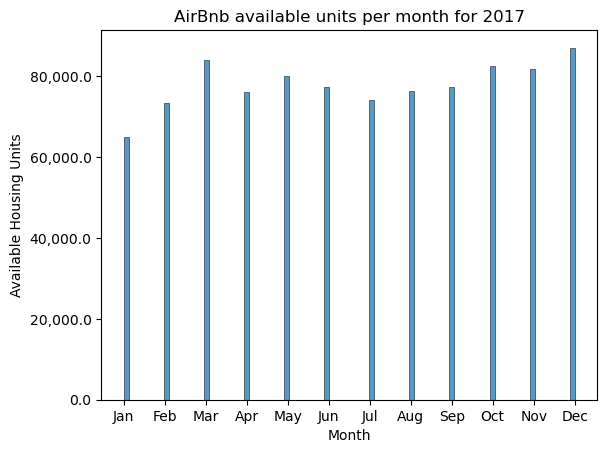

In [7]:
# plot the available units by month to visually represent the information above
fig, ax = plt.subplots()
sns.histplot(data=available_only_df,x='month')
ax.set_xticks(range(1,13,1)) # <--- set the ticks first
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.get_yaxis().set_major_formatter(mplib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(x)))
dummy = ax.set(xlabel='Month',
       ylabel='Available Housing Units',
       title='AirBnb available units per month for 2017')

plt.savefig('AirBnb available units per month for 2017.png')

In [ ]:
# The plot shows that December, March, and October are the 3 months with the most
# available units

In [8]:
# create a dataframe from the calendar dataframe dropping any rows where 
# the price is null
all_prices_df = calendar_df.dropna(subset=['price'])

In [9]:
# list the min and max prices from the prices dataframe
query = '''
    select 
        max(price),
        min(price)
    from
        all_prices_df
    '''
min_max_price_df = sqldf(query)
min_max_price_df

,max(price),min(price)
0,1650.0,10.0


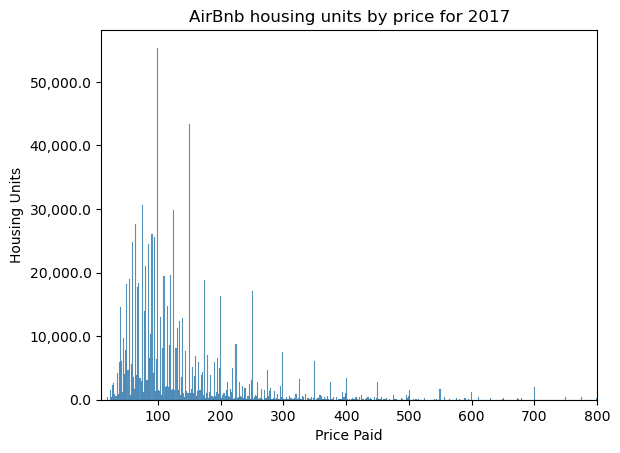

In [10]:
fig, ax = plt.subplots()
sns.histplot(data=all_prices_df,x='price')
ax.set_xlim(10,800)
ax.get_yaxis().set_major_formatter(mplib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(x)))
dummy = ax.set(xlabel='Price Paid',
       ylabel='Housing Units',
       title='AirBnb housing units by price for 2017')
plt.savefig('AirBnb housing units by price for 2017.png')

In [ ]:
# The plot shows the majority of rental units cost between 50 and 200 dollars with
# 100 dollars being the most frequent price

In [11]:
# display the first few rows of the reviews dataframe
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [13]:
# the goal is to determine which components are most predictive of the overall
# rating given to a listing

# create a new with only the specific components that people can rate the listing on plus the overall rating
# drop any rows where all the values are null
# drop any rows where the overall rating is null
# fill any missing values with the mean of the value for that column
review_scores_df = listings_df[['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location', 'review_scores_value']]
review_scores_df = review_scores_df.dropna(how='all')
review_scores_df = review_scores_df.dropna(subset=['review_scores_rating'])
review_scores_df = review_scores_df.fillna(review_scores_df.mean())

In [14]:
# normalize the data in the dataframe
scaler = StandardScaler()
review_scores_df_std = scaler.fit_transform(review_scores_df)
review_scores_df = pd.DataFrame(review_scores_df_std, columns=review_scores_df.columns)

In [15]:
# run a linear regression on the dataframe to assign weights to the score components
X = review_scores_df[review_scores_df.columns.difference(["review_scores_rating"])]
y = review_scores_df["review_scores_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.6485531047095806 on 952 values.'

In [16]:
# define a function to extract the coefficients from the regression model 
# and order them highest to lowest
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
5,review_scores_value,0.346846,0.346846
2,review_scores_cleanliness,0.283659,0.283659
0,review_scores_accuracy,0.161070,0.161070
1,review_scores_checkin,0.116514,0.116514
3,review_scores_communication,0.108917,0.108917
4,review_scores_location,0.050779,0.050779


In [ ]:
# The output indicates that value is the most important quality contributing 
# to the overall score given to a listing followed by cleanliness